# BERT Classifier

Use Yujia's BERT classifier code with all the new data we got.

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Import-Packages-and-Load-Data" data-toc-modified-id="Import-Packages-and-Load-Data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Import Packages and Load Data</a></span><ul class="toc-item"><li><span><a href="#Load-Data" data-toc-modified-id="Load-Data-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Load Data</a></span></li><li><span><a href="#Prepare-GPU" data-toc-modified-id="Prepare-GPU-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Prepare GPU</a></span></li></ul></li><li><span><a href="#Data-Pre-Processing" data-toc-modified-id="Data-Pre-Processing-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Data Pre-Processing</a></span><ul class="toc-item"><li><span><a href="#BERT-Tokenizer-and-Padding" data-toc-modified-id="BERT-Tokenizer-and-Padding-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>BERT Tokenizer and Padding</a></span></li><li><span><a href="#Attention-Masks" data-toc-modified-id="Attention-Masks-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Attention Masks</a></span></li></ul></li><li><span><a href="#Prepare-Model" data-toc-modified-id="Prepare-Model-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Prepare Model</a></span><ul class="toc-item"><li><span><a href="#Train-Test-Split" data-toc-modified-id="Train-Test-Split-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Train Test Split</a></span></li><li><span><a href="#Multilabel-Classifier" data-toc-modified-id="Multilabel-Classifier-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Multilabel Classifier</a></span></li><li><span><a href="#Classifier-per-Topic" data-toc-modified-id="Classifier-per-Topic-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Classifier per Topic</a></span></li><li><span><a href="#Train---Test-Curve" data-toc-modified-id="Train---Test-Curve-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Train - Test Curve</a></span></li><li><span><a href="#Evaluation" data-toc-modified-id="Evaluation-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>Evaluation</a></span></li></ul></li><li><span><a href="#Run-Model" data-toc-modified-id="Run-Model-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Run Model</a></span><ul class="toc-item"><li><span><a href="#Data-Preparation" data-toc-modified-id="Data-Preparation-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Data Preparation</a></span></li></ul></li><li><span><a href="#Save-Trained-Models" data-toc-modified-id="Save-Trained-Models-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Save Trained Models</a></span></li></ul></div>

In [1]:
batch_size=4
gpu_id=1
epochs = 4
topics = topic_to_id.keys()
# topics = ['child product', 'mom health', 'child milestones']

In [2]:
# device = torch.device(1)
# if device.type == 'cuda':
#     print(torch.cuda.get_device_name(torch.cuda.current_device()))
#     print('Memory Usage:')
#     print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
#     print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')

## Import Packages and Load Data

Can be later changed to pull data from GitHub, but for now just do it from a local path.

In [3]:
# Input data files are available in the "../data/" directory.
import pickle
import os
print(os.listdir("../data"))

# Basics + Viz
import time
import datetime
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import seaborn as sns

# Pre-processing
from transformers import BertTokenizer
from keras.preprocessing.sequence import pad_sequences

# Models
from sklearn.model_selection import train_test_split
from transformers import BertForSequenceClassification, AdamW, BertConfig
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import get_linear_schedule_with_warmup

# Metrics
from sklearn.metrics import classification_report
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

# Suppress warnings
import warnings
from sklearn.exceptions import UndefinedMetricWarning
warnings.filterwarnings(action='ignore', category=UndefinedMetricWarning)

# # Memory Debugging
# from pytorch_memlab import profile, set_target_gpu

# set_target_gpu(gpu_id)

['20200422-multilabel.h5', '.ipynb_checkpoints', 'facebook', '0527_reddit_1300_parenting_clean.csv', 'extra_data', 'labeled_only-reddit_796_of_1300.h5', '20200405-topic_to_id.pickle', '20200405-topic_per_row.h5']


Using TensorFlow backend.


### Load Data

In [4]:
# load dictionary
with open("../data/20200405-topic_to_id.pickle", "rb") as input_file:
    topic_to_id = pickle.load(input_file)

# load data
data_folder = '../data/extra_data/aug/'
df = pd.DataFrame()
file_names = os.listdir(data_folder)

for f in file_names:
    temp = pd.read_csv(data_folder + f)
    print(temp.shape)
    df = pd.concat([df, temp])

print(f"Total: {df.shape}")

(259, 33)
(665, 33)
(59, 33)
(590, 33)
(796, 33)
(249, 33)
Total: (2618, 33)


### Prepare GPU 

In [5]:
# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device(gpu_id)

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(torch.cuda.current_device()))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 2 GPU(s) available.
We will use the GPU: GeForce RTX 2080 Ti


## Data Pre-Processing

Use https://github.com/huggingface/transformers BERTTokenizer to change all the words into IDs.

### BERT Tokenizer and Padding

In [6]:
# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...


In [7]:
# Set the maximum sequence length.
MAX_LEN = 512

sentence_lengths = []
def tokenize_and_count(s, lst, max_len):
    # `encode` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    answer = tokenizer.encode(s, add_special_tokens=True)
    lst.append(len(answer))
    
    return answer

df['bert'] = df.text.apply(lambda s : tokenize_and_count(s, sentence_lengths, MAX_LEN))
df['bert_aug'] = df.aug.apply(lambda s : tokenize_and_count(s, sentence_lengths, MAX_LEN))

Token indices sequence length is longer than the specified maximum sequence length for this model (601 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (580 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (544 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (835 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (662 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for thi

Token indices sequence length is longer than the specified maximum sequence length for this model (846 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (623 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1082 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (567 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (562 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for th

It's obvious the default MAX_LEN=512 is not enough for some posts, but just how long are these posts?<br>
<br>
Turns out only 2% of all the sentences are above the length 512.<br>
So we'll just proceed as normal and truncate/extend all the sentences to length 512, as most sentences are distributed between the 100~200 word range, we don't want to add too many padding to most sentences by setting the MAX_LEN to something too high.

In [8]:
max_len = 512
temp = np.array(sentence_lengths)
temp_count = len(temp[temp > max_len])
temp_len = len(sentence_lengths)

print(f"Out of the\n{temp_len} total sentences,\n{temp_count} are over the length {max_len},\nTotal of: {(temp_count/temp_len * 100):.2f}%")

Out of the
5236 total sentences,
55 are over the length 512,
Total of: 1.05%


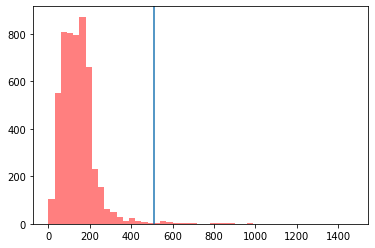

In [9]:
n, bins, patches = plt.hist(sentence_lengths, bins=[30 * i for i in range(50)], facecolor='red', alpha=0.5)
_ = plt.axvline(512)

In [10]:
# Pad our input tokens with value 0.
# "post" indicates that we want to pad and truncate at the end of the sequence,
# as opposed to the beginning.
df['bert'] = pad_sequences(df['bert'].values, maxlen=MAX_LEN, dtype="long", 
                          value=0, truncating="post", padding="post").tolist()
df['bert_aug'] = pad_sequences(df['bert_aug'].values, maxlen=MAX_LEN, dtype="long", 
                          value=0, truncating="post", padding="post").tolist()

### Attention Masks

Source: https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
<br>
Attention masks are used to filter out the padding from each sentence. A simple format of 1 for a real word and 0 for padding.

In [11]:
# Create attention masks
df['attention'] = df['bert'].apply(lambda arr : [int(token_id > 0) for token_id in arr])
df['attention_aug'] = df['bert_aug'].apply(lambda arr : [int(token_id > 0) for token_id in arr])

## Prepare Model

### Train Test Split

In [12]:
test_size = 0.2
train_df, test_df = train_test_split(df, random_state=42, test_size=test_size)

print(f"{test_size} split\n{train_df.shape[0]} lines of training data,\n{test_df.shape[0]} lines of test data")

0.2 split
2094 lines of training data,
524 lines of test data


### Multilabel Classifier
__[TODO]__ Turns out this is harder to do. Figure this out later.

For this classifier we are going to throw in all 30 labels as one big multilabel.<br>
This is happening first mostly because it's easier to implement.

### Classifier per Topic

__[TODO]__ Check if declaring those tensors on the device does anything.

Recommended hyperparameter values
Batch size: 16, 32
Learning rate (Adam): 5e-5, 3e-5, 2e-5
Number of epochs: 2, 3, 4

In [13]:
# Define some util functions

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    try:
        roc = roc_auc_score(pred_flat, labels_flat)
    except ValueError:
        roc = 0
    return f1_score(pred_flat, labels_flat), roc, np.sum(pred_flat == labels_flat) / len(labels_flat)

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))

Define the training script

In [14]:
def single_topic_train(model, epochs, train_dataloader, test_dataloader, seed_val=42, verbose=False):
    # This training code is based on the `run_glue.py` script here:
    # https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

    # Set the seed value all over the place to make this reproducible.
    random.seed(seed_val)
    np.random.seed(seed_val)
    torch.manual_seed(seed_val)
    torch.cuda.manual_seed_all(seed_val)
    
    # Store the average loss after each epoch so we can plot them.
    training_losses = []
    testing_losses = []
    
    for epoch_i in range(0, epochs):
        # ========================================
        #               Training
        # ========================================

        # Perform one full pass over the training set.
        if verbose:
            print("")
            print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
            print('Training...')
        
        # Measure how long the training epoch takes.
        t0 = time.time()

        # Reset the total loss for this epoch.
        total_train_loss = 0

        # Put the model into training mode.
        model.train()
        
        # For each batch of training data...
        for step, batch in enumerate(train_dataloader):

            if step % 40 == 0 and not step == 0:
                elapsed = format_time(time.time() - t0)

                # Report progress.
                if verbose:
                    print(f'  Batch {step:>5,}  of  {len(train_dataloader):>5,}.    Elapsed: {elapsed:}.')

            # `batch` contains three pytorch tensors:
            #   [0]: input ids 
            #   [1]: attention masks
            #   [2]: labels 
            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)

            model.zero_grad()        

            outputs = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask, 
                        labels=b_labels)

            loss = outputs[0]
            total_train_loss += outputs[0].item()

            loss.backward()

            # Clip the norm of the gradients to 1.0.
            # This is to help prevent the "exploding gradients" problem.
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update parameters and take a step using the computed gradient.
            optimizer.step()

            # Update the learning rate.
            scheduler.step()
        
        # Calculate the average loss over the training data.
        avg_train_loss = total_train_loss / len(train_dataloader)            
        training_losses.append(avg_train_loss)
        
        if verbose:
            print("")
            print("  Average training loss: {0:.2f}".format(avg_train_loss))
            print("  Training epoch took: {:}".format(format_time(time.time() - t0)))
        
        # ========================================
        #               Validation
        # ========================================
        # After the completion of each training epoch, measure our performance on
        # our validation set.

        if verbose:
            print("")
            print("Running Validation...")
        
        # Measure how long the testing takes.
        t0 = time.time()

        # Reset the total loss for this epoch.
        total_test_loss = 0

        # Put the model in evaluation mode--the dropout layers behave differently
        # during evaluation.
        model.eval()

        # Tracking variables 
        eval_loss, eval_accuracy, eval_f1, eval_auc = 0, 0, 0, 0
        nb_eval_steps, nb_eval_examples = 0, 0

        # Evaluate data for one epoch
        for batch in test_dataloader:

            # Add batch to GPU
            batch = tuple(t.to(device) for t in batch)

            # Unpack the inputs from our dataloader
            b_input_ids, b_input_mask, b_labels = batch

            # Telling the model not to compute or store gradients, saving memory and
            # speeding up validation
            with torch.no_grad():        
                outputs = model(b_input_ids, 
                                token_type_ids=None, 
                                attention_mask=b_input_mask, 
                                labels=b_labels)

            total_test_loss += outputs[0].item()

            logits = outputs[1]
            # Move logits and labels to CPU
            logits = logits.detach().cpu().numpy()
            label_ids = b_labels.to('cpu').numpy()

            # Calculate the accuracy for this batch of test sentences.
            tmp_eval_f1, tmp_eval_auc, tmp_eval_accuracy = flat_accuracy(logits, label_ids)

            # Accumulate the total accuracy.
            eval_accuracy += tmp_eval_accuracy
            eval_f1 += tmp_eval_f1
            eval_auc += tmp_eval_auc
            # Track the number of batches
            nb_eval_steps += 1

        avg_test_loss = total_test_loss / len(test_dataloader)            
        testing_losses.append(avg_test_loss)

        # Report the final accuracy for this validation run.
        if verbose:
            print("  F1 Score: {0:.2f}".format(eval_f1/nb_eval_steps))
            print("  ROC_AUC: {0:.2f}".format(eval_auc/nb_eval_steps))
            print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
            print("  Validation took: {:}".format(format_time(time.time() - t0)))
            print("  Average validation loss: {0:.2f}".format(avg_test_loss))
        
    return model, training_losses, testing_losses

### Train - Test Curve

In [15]:
def draw_test_train_curve(test_losses, train_losses, topic_name):
    # Use plot styling from seaborn.
    sns.set(style='darkgrid')

    # Increase the plot size and font size.
    sns.set(font_scale=1.5)
    plt.rcParams["figure.figsize"] = (12,6)

    # Plot the learning curve.
    plt.plot(train_losses, 'b-o', label='Train')
    plt.plot(test_losses, 'r-o', label='Test')

    # Label the plot.
    plt.title(f"Train/Test loss - {topic_name}")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.show()

### Evaluation

In [16]:
def run_evaluation(model, test_dataloader, verbose=False):
    # Put model in evaluation mode
    model.eval()
    
    # Tracking variables 
    predictions , true_labels = [], []

    # Predict 
    for batch in test_dataloader:
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)

        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch

        # Telling the model not to compute or store gradients, saving memory and 
        # speeding up prediction
        with torch.no_grad():
          # Forward pass, calculate logit predictions
          outputs = model(b_input_ids, token_type_ids=None, 
                          attention_mask=b_input_mask)

        logits = outputs[0]

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Store predictions and true labels
        predictions.append(logits)
        true_labels.append(label_ids)
        
    # Create results
    matthews_set = []

    # Evaluate each test batch using Matthew's correlation coefficient
    if verbose:
        print('Calculating Matthews Corr. Coef. for each batch...')

    # For each input batch...
    for i in range(len(true_labels)):
        # The predictions for this batch are a 2-column ndarray (one column for "0" 
        # and one column for "1"). Pick the label with the highest value and turn this
        # in to a list of 0s and 1s.
        pred_labels_i = np.argmax(predictions[i], axis=1).flatten()
        # Calculate and store the coef for this batch.  
        matthews = matthews_corrcoef(true_labels[i], pred_labels_i)
        
        if verbose:
            print("Predicted Label for Batch " + str(i) + " is " + str(pred_labels_i))
            print("True Label for Batch " + str(i) + " is " + str(true_labels[i])) 
            print("Matthew's correlation coefficient for Batch " + str(i) + " is " + str(matthews))
        matthews_set.append(matthews)
    
    # Combine the predictions for each batch into a single list of 0s and 1s.
    flat_predictions = [item for sublist in predictions for item in sublist]
    flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

    # Combine the correct labels for each batch into a single list.
    flat_true_labels = [item for sublist in true_labels for item in sublist]

    # Calculate the MCC
    mcc = matthews_corrcoef(flat_true_labels, flat_predictions)
    f1 = f1_score(flat_true_labels, flat_predictions)
    ra = roc_auc_score(flat_true_labels, flat_predictions)

    cm = confusion_matrix(flat_true_labels, flat_predictions)
    sns.heatmap(cm, annot=True)
    plt.show()

    print('MCC: %.3f' % mcc)
    print('ROC_AUC: %.3f' % ra)
    print('F1: %.3f' % f1)
    print(classification_report(flat_true_labels, flat_predictions))

## Run Model

Run all the training for the topics we want to run.<br>
Later, when we are sure of the model we're to use, we'll be running it for all 30 topics.

### Data Preparation

We have augmented data within the same DataFrame as a separate column. Get it out.

In [17]:
def augmented_dataloader(train_df, test_df, topic, batch_size):
    # Test data should NOT have any augmented data in it.
    # Therefore the process is the same as the past.
    test_x = torch.tensor(test_df.bert.values.tolist())
    test_y = torch.tensor(test_df[topic].values.astype(int))
    test_masks = torch.tensor(test_df.attention.values.tolist())
    
    test_data = TensorDataset(test_x, test_masks, test_y)
    test_sampler = SequentialSampler(test_data)
    test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)
    
    # Train data should have the augmented data added.
    # BUT we only want the positive cased augmented. No need in throwing in more negative cases.
    aug_index = train_df[topic] == 1
    
    train_x = train_df.bert.values.tolist() + train_df.bert_aug[aug_index].values.tolist()
    train_y = train_df[topic].values.astype(int).tolist() + train_df[topic][aug_index].values.astype(int).tolist()
    train_masks = train_df.attention.values.tolist() + train_df.attention[aug_index].values.tolist()
    
    train_x = torch.tensor(train_x)
    train_y = torch.tensor(train_y)
    train_masks = torch.tensor(train_masks)
    
    train_data = TensorDataset(train_x, train_masks, train_y)
    train_sampler = RandomSampler(train_data)
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
    
    return train_dataloader, test_dataloader

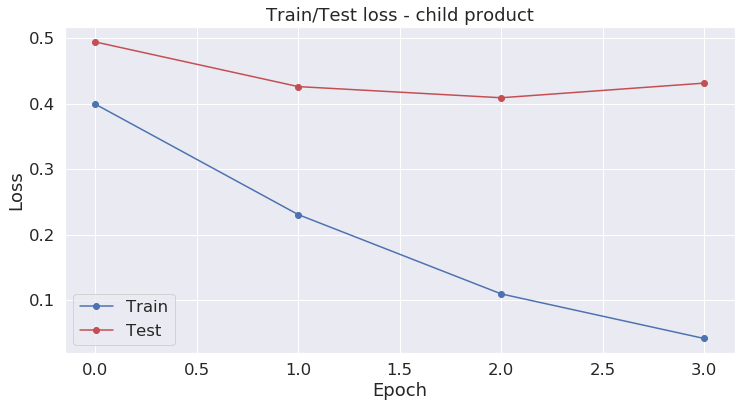

EVALUATION
TOPIC: child product


/home/jupyter-jinu_jang/.conda/envs/nlp/lib/python3.6/site-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


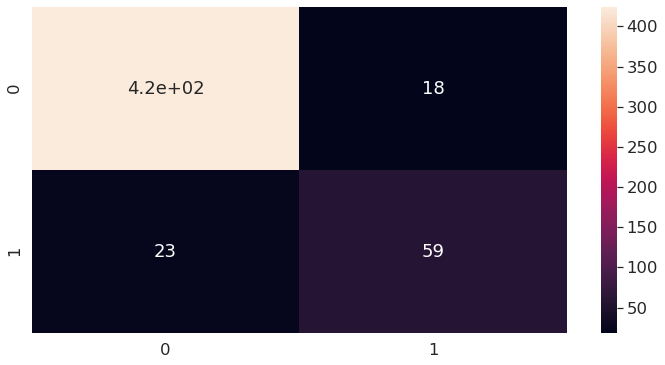

MCC: 0.697
ROC_AUC: 0.839
F1: 0.742
              precision    recall  f1-score   support

           0       0.95      0.96      0.95       442
           1       0.77      0.72      0.74        82

    accuracy                           0.92       524
   macro avg       0.86      0.84      0.85       524
weighted avg       0.92      0.92      0.92       524



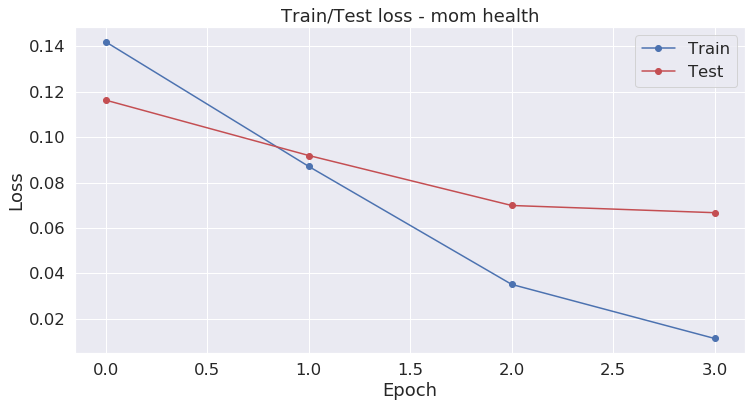

EVALUATION
TOPIC: mom health


/home/jupyter-jinu_jang/.conda/envs/nlp/lib/python3.6/site-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


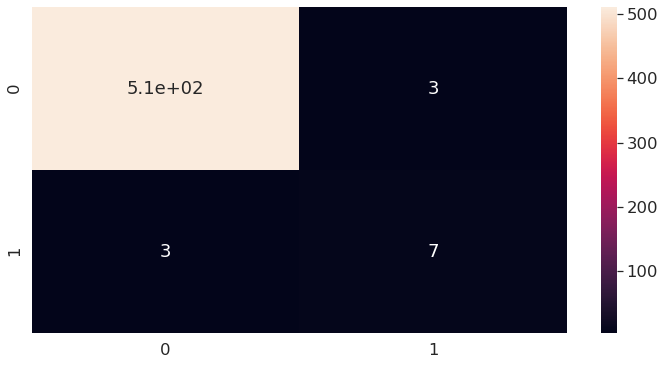

MCC: 0.694
ROC_AUC: 0.847
F1: 0.700
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       514
           1       0.70      0.70      0.70        10

    accuracy                           0.99       524
   macro avg       0.85      0.85      0.85       524
weighted avg       0.99      0.99      0.99       524



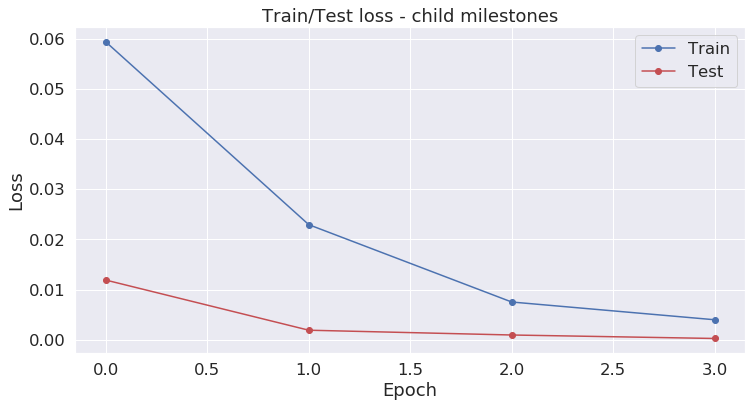

EVALUATION
TOPIC: child milestones


/home/jupyter-jinu_jang/.conda/envs/nlp/lib/python3.6/site-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


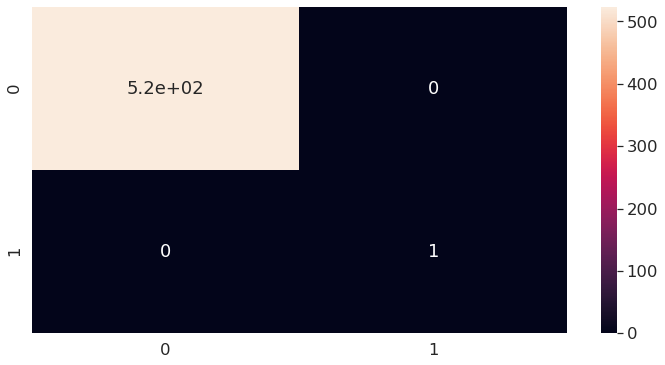

MCC: 1.000
ROC_AUC: 1.000
F1: 1.000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       523
           1       1.00      1.00      1.00         1

    accuracy                           1.00       524
   macro avg       1.00      1.00      1.00       524
weighted avg       1.00      1.00      1.00       524



In [18]:
# Create x, y for each
for topic in topics:
    train_dataloader, test_dataloader = augmented_dataloader(train_df, test_df, topic, batch_size)
    
    # Then load the pretrained BERT model (has linear classification layer on top)
    model = BertForSequenceClassification.from_pretrained(
        "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
        num_labels = 2, # The number of output labels--2 for binary classification.
                        # You can increase this for multi-class tasks.   
        output_attentions = False, # Whether the model returns attentions weights.
        output_hidden_states = False, # Whether the model returns all hidden-states.
    )

    model.cuda(device=device)
    
    # load optimizer
    optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )
    
    # Total number of training steps is [number of batches] x [number of epochs]. 
    total_steps = len(train_dataloader) * epochs
    scheduler = get_linear_schedule_with_warmup(optimizer, 
                                                num_warmup_steps = 0,
                                                num_training_steps = total_steps)
    
    model, train_losses, test_losses = single_topic_train(model, epochs,
                                                    train_dataloader,
                                                    test_dataloader,
                                                    seed_val=42)
    
    # Visualize test and train curve
    draw_test_train_curve(test_losses, train_losses, topic)
    
    # Evaluation results
    print("====================")
    print("====================")
    print("EVALUATION")
    print(f"TOPIC: {topic}")
    run_evaluation(model, test_dataloader, verbose=False)

## Save Trained Models

In [19]:
# # Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

# output_dir = './{}_model_save/'.format("child_product".replace(' ', '_'))
# print(output_dir)
# # Create output directory if needed
# if not os.path.exists(output_dir):
#     os.makedirs(output_dir)

# print("Saving model to %s" % output_dir)

# # Save a trained model, configuration and tokenizer using `save_pretrained()`.
# # They can then be reloaded using `from_pretrained()`
# model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
# model_to_save.save_pretrained(output_dir)
# tokenizer.save_pretrained(output_dir)

# # Good practice: save your training arguments together with the trained model
# # torch.save(args, os.path.join(output_dir, 'training_args.bin'))